### What is Routing in langGraph? 

Routing in langGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using: 

- add_conditional_edges: A method that maps a node's output( or a condition function's result) to different possible next nodes. 

- state: The workflow's state can store variables that influence routing decisions. 

- condition functions : functions that evaluate the state or node output to decide the next step.


#### Key concepts 

- Dynamic flow: Unlike a linear sequence, routing lets a graph adapt to intermediate results.

- condition logic : you define rules (eg: "if this ,go here ; if that , go there ").

- flexibility: combines well with parallelization or sequential chains for complex workflow.



In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()

from langchain_groq import ChatGroq 
from langchain_openai import ChatOpenAI
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

llm=ChatGroq(model="openai/gpt-oss-120b")
# llm=ChatOpenAI(model="gpt-5-2025-08-07")

In [3]:
from typing_extensions import Literal
from typing import TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage


# Schema for structured output to use as routing logic.
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="This next step in the routing process")

## Augment the llm with schema for structured output
router=llm.with_structured_output(Route)

## state 
class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call_1(state:State):
    """write a story"""
    result=llm.invoke(state['input'])
    return {"output":result.content}

def llm_call_2(state:State):
    """write a joke"""

    print("llm call 2 is called")
    result=llm.invoke(state['input'])
    return {"output":result.content}

def llm_call_3(state:State):
    """write a poem"""

    print("llm call 3 is called")
    result=llm.invoke(state['input'])
    return {"output":result.content}

def llm_call_router(state:State):
    """ Route the input to the appropriate node."""

    decision=router.invoke(

        [
            SystemMessage(
                content="Route the input to story , joke or poem based on the users request."
            ),
        
        HumanMessage(
            content=state['input']
        )
        ]
    )

    return {"decision":decision.step}


## conditional edge function to route to the appropriate node 

def route_decision(state:State):

    # return the node name you want to visit next
    if state['decision']=='story':
        return "llm_call_1"
    elif state['decision']=="joke":
        return "llm_call_2"
    elif state['decision']=='poem':
        return "llm_call_3"

In [15]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

builder=StateGraph(State)

builder.add_node("llm_call_1",llm_call_1)
builder.add_node("llm_call_2",llm_call_2)
builder.add_node("llm_call_3",llm_call_3)
builder.add_node("llm_call_router",llm_call_router)

# adding edges 

builder.add_edge(START,"llm_call_router")
builder.add_conditional_edges("llm_call_router",route_decision,{"llm_call_1":"llm_call_1","llm_call_2":"llm_call_2","llm_call_3":"llm_call_3"})
builder.add_edge("llm_call_1",END)
builder.add_edge("llm_call_2",END)
builder.add_edge("llm_call_3",END)

graph=builder.compile()

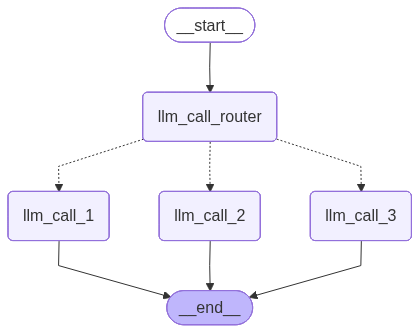

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))